In [3]:
#This file is designed to export gas data of the snapshots into a file that can be used to create plots with gas in the background
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import os
import pickle
import matplotlib
import matplotlib.colors as colors
import gizmo_analysis as gizmo
import astropy
from astropy.io import ascii
#############################################################################
#constants
#############################################################################
MsunToGm = 1.99e33
KpcToCm = 3.086e21
mp = 1.67e-24
#bin_edge = 10.
bin_edge = 30.
bins = np.arange(-25,25,0.1)

In [4]:
## NOTE: Inputs can be either position or velocity in the "Translated Box Coordinate Frame"
## If inputs are positions in the "Translated Box Coordinate Frame", outputs will be positions in the "Loebman Lab Coordinate Frame"
## If inputs are velocities in the "Translated Box Coordinate Frame", outputs will be velocities in the "Loebman Lab Coordinate Frame"

def ll_coordinate_transformation(rotation_matrix, x_translated_box_coordinate, y_translated_box_coordinate, z_translated_box_coordinate):
    
    # identifying the elements of the True Rotation Matrix
    rot_mat11 = rotation_matrix[0][0][0]
    rot_mat12 = rotation_matrix[0][0][1]
    rot_mat13 = rotation_matrix[0][0][2]
    
    rot_mat21 = rotation_matrix[0][1][0]
    rot_mat22 = rotation_matrix[0][1][1]
    rot_mat23 = rotation_matrix[0][1][2]
    
    rot_mat31 = rotation_matrix[0][2][0]
    rot_mat32 = rotation_matrix[0][2][1]
    rot_mat33 = rotation_matrix[0][2][2]
    
    ''' 
        Finding the three "True Rotation Angles": rot_angle_0, rot_angle_1 and rot_angle_2
        
        Note that there are eight possible sets of rotation angles.

        We use the following approach to know which set of rotation angles is the "True Rotation Angles" set.
        For each of the eight possible sets of rotation angles, 
        we compute the rotation matrix (let's call it the Recovered Rotation Matrix), 
        and we check which of these "Recovered Rotation Matrices" matches the "True Rotation Matrix."
        
    '''
    
    rot_angle_0 = [] 
    rot_angle_1 = []
    rot_angle_2 = []

    for k in range (2):
        for j in range (2):
            for i in range (2):
                recovered_rotation_angles = [0, 0, 0]
                recovered_rotation_angles[0] =  np.arctan(-rot_mat32/rot_mat33) + (i*np.pi)
                recovered_rotation_angles[1] =  np.arctan(rot_mat31/(np.sqrt(1- (rot_mat31**2)))) + (j*np.pi)
                recovered_rotation_angles[2] =  np.arctan(-rot_mat21/rot_mat11) + (k*np.pi)

                recovered_rot_mat11 = np.cos(recovered_rotation_angles[1]) * np.cos(recovered_rotation_angles[2])
                recovered_rot_mat12 = np.cos(recovered_rotation_angles[0]) * np.sin(recovered_rotation_angles[2]) + np.sin(recovered_rotation_angles[0]) * np.sin(recovered_rotation_angles[1]) * np.cos(recovered_rotation_angles[2])
                recovered_rot_mat13 = np.sin(recovered_rotation_angles[0]) * np.sin(recovered_rotation_angles[2]) - np.cos(recovered_rotation_angles[0]) * np.sin(recovered_rotation_angles[1]) * np.cos(recovered_rotation_angles[2])
                recovered_rot_mat21 = -np.cos(recovered_rotation_angles[1]) * np.sin(recovered_rotation_angles[2])
                recovered_rot_mat22 = np.cos(recovered_rotation_angles[0]) * np.cos(recovered_rotation_angles[2]) - np.sin(recovered_rotation_angles[0]) * np.sin(recovered_rotation_angles[1]) * np.sin(recovered_rotation_angles[2])
                recovered_rot_mat23 = np.sin(recovered_rotation_angles[0]) * np.cos(recovered_rotation_angles[2]) + np.cos(recovered_rotation_angles[0]) * np.sin(recovered_rotation_angles[1]) * np.sin(recovered_rotation_angles[2])
                recovered_rot_mat31 = np.sin(recovered_rotation_angles[1])
                recovered_rot_mat32 = -np.sin(recovered_rotation_angles[0]) * np.cos(recovered_rotation_angles[1])
                recovered_rot_mat33 = np.cos(recovered_rotation_angles[0]) * np.cos(recovered_rotation_angles[1])

                if ((np.round(recovered_rot_mat11.astype('float64'), 3) == np.round(rot_mat11.astype('float64'), 3)) & 
                    (np.round(recovered_rot_mat12.astype('float64'), 3) == np.round(rot_mat12.astype('float64'), 3)) & 
                    (np.round(recovered_rot_mat13.astype('float64'), 3) == np.round(rot_mat13.astype('float64'), 3)) &
                    (np.round(recovered_rot_mat21.astype('float64'), 3) == np.round(rot_mat21.astype('float64'), 3)) &
                    (np.round(recovered_rot_mat22.astype('float64'), 3) == np.round(rot_mat22.astype('float64'), 3)) &
                    (np.round(recovered_rot_mat23.astype('float64'), 3) == np.round(rot_mat23.astype('float64'), 3)) &
                    (np.round(recovered_rot_mat31.astype('float64'), 3) == np.round(rot_mat31.astype('float64'), 3)) &
                    (np.round(recovered_rot_mat32.astype('float64'), 3) == np.round(rot_mat32.astype('float64'), 3)) &
                    (np.round(recovered_rot_mat33.astype('float64'), 3) == np.round(rot_mat33.astype('float64'), 3))):

                    rot_angle_0.append(recovered_rotation_angles[0])
                    rot_angle_1.append(recovered_rotation_angles[1])
                    rot_angle_2.append(recovered_rotation_angles[2])

                    break
                    del(recovered_rotation_angles)
                    
    ''' 
        Constructing the "Loebman Lab Transformation Matrix": ll_tans_matij   
    '''
    
    ll_trans_mat11 = np.cos(rot_angle_1)
    ll_trans_mat12 = np.sin(rot_angle_0) * np.sin(rot_angle_1)
    ll_trans_mat13 = - np.cos(rot_angle_0) * np.sin(rot_angle_1)
    ll_trans_mat21 = np.zeros(1)
    ll_trans_mat22 = np.cos(rot_angle_0)
    ll_trans_mat23 = np.sin(rot_angle_0) 
    ll_trans_mat31 = np.sin(rot_angle_1)
    ll_trans_mat32 = -np.sin(rot_angle_0) * np.cos(rot_angle_1)
    ll_trans_mat33 = np.cos(rot_angle_0) * np.cos(rot_angle_1)
    
    '''
        Finding coordinate of particles in the "Loebman Lab Coordinate System": x_ll, y_ll and z_ll
    '''
    
    x_ll = (ll_trans_mat11*x_translated_box_coordinate) + (ll_trans_mat12*y_translated_box_coordinate) + (ll_trans_mat13*z_translated_box_coordinate)
    y_ll = (ll_trans_mat21*x_translated_box_coordinate) + (ll_trans_mat22*y_translated_box_coordinate) + (ll_trans_mat23*z_translated_box_coordinate)
    z_ll = (ll_trans_mat31*x_translated_box_coordinate) + (ll_trans_mat32*y_translated_box_coordinate) + (ll_trans_mat33*z_translated_box_coordinate)
    
    position_ll = np.asarray((x_ll, y_ll, z_ll)).T
    
    return position_ll   

In [6]:
############################################################################
#read in sim files and find relevant particles
############################################################################
simname = 'm12f_res7100_mhdcv'
simtype="fire2"  #this is the simtype eg. fire2, fire3, sf-fire3, sf-fire3-alpha01, sf-fire3-alpha03, sf-fire3-alpha05 
simdir = '/scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12f_r7100/mhdcv/1Myr/'
work_data_path="/home1/07428/binod/work2/data/gas_data/"
gas_datapath=work_data_path+simname+"_gas_data_pkl_ll_coordinates/"  #path to store the gas data
if not os.path.exists(gas_datapath):
    os.makedirs(gas_datapath)
                
#snap=596 #this is the snapshot at which the clusters were taken from using the fof algorithm I am using this to extract information from the snapshot where the clusters were first seen
snapshot_start=588  #snapshot to begin creating the figure
snapshot_end=588    #snapshot to stop at

snapshot_list=np.arange(snapshot_start,snapshot_end+1) #create a list of snapshot numbers to plot to plot eg. [596,597, ...]
time=snapshot_list-snapshot_start #time starts from zero here where t=0 is at the snapshot where we start from eg. [0,1,2,3,....]

#reading in snapshot_times.txt file to get snapshot numbers and times
# columns are: snapshot scale-factor redshift time[Gyr] time_width[Myr]
snapshot_times = simdir + 'snapshot_times.txt'
snaptime_data = astropy.io.ascii.read(snapshot_times, guess=False, comment="#")
snaptime_data = np.genfromtxt(snapshot_times, usecols=(0,3), skip_header=4, dtype=float) #the first and fourth columns are the only ones we need 
snaps = np.array(snaptime_data[:,0]) #col1 = first column saved from text file #This is a collection of all snapshot nos.
times = np.array(snaptime_data[:,1]) #col4 = second column saved #This is a collection of times equivalent to those snapshot nos.
#######################################
#######################################

In [7]:
tracked_gas_all_snaps={}
for i in range(len(time)):                              
    snapnumber=time[i]+snapshot_start      #this is the true snapshot number each time for eg, 596, 597 .. and son
    snaptime = times[np.where(snaps == snapnumber)][0] #time of snapshot in Gyr
    tracked_gas={} 
    part = gizmo.io.Read.read_snapshots(['all'],'snapshot_index', time[i]+snapshot_start, simulation_name=simname, simulation_directory=simdir, assign_hosts_rotation=True, assign_hosts=True)  
    t = np.max(part['star'].prop('form.time'))  
    
    rGas = part['gas'].prop('host.distance.principal.cylindrical')[:,0]
    
    #xGas = part['gas'].prop('host.distance.principal.cartesian')[:,0]
    #yGas = part['gas'].prop('host.distance.principal.cartesian')[:,1]
    #zGas = part['gas'].prop('host.distance.principal.cartesian')[:,2]
    
    
    xGas = part['gas'].prop('host.distance')[:,0]
    yGas = part['gas'].prop('host.distance')[:,1]
    zGas = part['gas'].prop('host.distance')[:,2]
    
    #vxGas = part['gas'].prop('host.velocity.principal.cartesian')[:,0]
    #vyGas = part['gas'].prop('host.velocity.principal.cartesian')[:,1]
    #vzGas = part['gas'].prop('host.velocity.principal.cartesian')[:,2]
    
    mGas = part['gas']['mass']
    rhoGas = part['gas']['density']
    tGas = part['gas']['temperature']
    idGas = part['gas']['id']
    
    i_gas = np.where((rGas <= bin_edge) & (np.fabs(zGas) <= 1.5) & (part['gas']['density']*((MsunToGm/KpcToCm**3)/mp) >= 10.) & (tGas <= 1e4))
    
    x = xGas[i_gas]
    y = yGas[i_gas]
    z = zGas[i_gas]
    
    
    #vx = vxGas[i_gas]
    #vy = vyGas[i_gas]
    #vz = vzGas[i_gas]
    #m = mGas[i_gas]
    rho = part['gas'].prop('number.density')[i_gas]
    id = part['gas']['id'][i_gas]
    
    ###########################################################################
    #gas image (2d histogram)
    ###########################################################################
    #cold (< 10^4 K) gas in the midplane (|z| <= 1.5 kpc within bin_edge
    v =  np.where((rGas <= bin_edge) & (np.fabs(zGas) <= 1.5) & (tGas <= 1e4))
    face, xh, yh = np.histogram2d(part['gas'].prop('host.distance.principal.cartesian')[v,1][0],part['gas'].prop('host.distance.principal.cartesian')[v,0][0],bins=[bins,bins], weights=part['gas']['mass'][v])

    ###########################################################################
    tracked_gas={"snaptime":snaptime,"v":v,"face":face,"xh":xh,"yh":yh}
    file_name=simtype+"_gas_data"+str(snapnumber)+".pkl"
    with open(gas_datapath+file_name, 'wb') as output:
        pickle.dump(tracked_gas, output)
    print("\n Stored the gas data for background plot from the snapshot no.",snapnumber,"to filename:",file_name,"\n#####\n")
    '''
    This is how to read the data:
    file_name="gas_data_snapshot_"+str(snapnumber)+".pkl"
    with open(gas_datapath+file_name, "rb") as input:
      import_gasdata = pickle.load(input)
    print(import_gasdata["v"])
    '''
    #tracked_gas_all_snaps.update({snapnumber:tracked_gas})
###########################################
#storing all the gas data from all snapshots as a single file
'''
with open(gas_datapath+simtype+"_gas_data_all_snapshots.pkl", 'wb') as output:
  pickle.dump(tracked_gas_all_snaps, output) #
  
#read it as tracked_gas_all_snaps[snap]["v"]
'''


# in utilities.simulation.Snapshot():
* reading:  scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12f_r7100/mhdcv/1Myr/snapshot_times.txt

  using snapshot index = 588, redshift = 0.008


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12f_r7100/mhdcv/1Myr/output/snapshot_588.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 81363848 particles
    dark2     (id = 2): 7086235 particles
    gas       (id = 0): 64175509 particles
    star      (id = 4): 17775662 particles
    blackhole (id = 5): 0 particles

* reading the following
  species: ['dark', 'dark2', 'gas', 'star']
  gas properties: ['density', 'electron.fraction', 'hydrogen.neutral.fraction', 'id', 'id.child', 'id.generation', 'magnetic.field', 'mass', 'massfraction', 'position', 'sfr', 'size', 'temperature', 'velocity']

* reading particles from:
    scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12f_r7100/mhdcv/1Myr/output/snapsho

'\nwith open(gas_datapath+simtype+"_gas_data_all_snapshots.pkl", \'wb\') as output:\n  pickle.dump(tracked_gas_all_snaps, output) #\n  \n#read it as tracked_gas_all_snaps[snap]["v"]\n'

In [4]:
def get_gas_plot(v,face,xh,yh):
    
    from matplotlib import pyplot as plt
    fig1=plt.figure()
    fig1.set_size_inches(7,7)
    ax=fig1.add_axes([0.17, 0.185, 0.65, 0.65]) #left, bottom, width, height
    bin_edge = 30.
    #bins = np.arange(-5,5,0.1)
    bins = np.arange(-25,25,0.1)
    norm = matplotlib.colors.LogNorm(vmin=1, vmax=1000) #the color range plotted
    im = ax.imshow(face/(((bins[1]-bins[0])*1000)**2),origin='lower',interpolation='nearest',norm=norm,extent=(-25,25,-25,25),cmap='binary') 

    #colorbar for the background gas density
    cmap_gray = matplotlib.cm.get_cmap('binary')
    norm1 = matplotlib.colors.LogNorm(vmin=1,vmax=1000)
    cbar_ax1 = fig1.add_axes([0.04, 0.185, 0.04, 0.64]) # position of gray colorbar (left, bottom, width, height)
    cb1 = fig1.colorbar(im, cax=cbar_ax1, ticklocation='left')
    cb1.set_label('$\Sigma$ (M$_{{\odot}}$/pc$^2$)', labelpad=-5, fontsize=12)
    #plot a scale bar 5 kpc long
    ax.plot([-22.5,-17.5], [22.5,22.5], 'k-', linewidth=5)
    label1 = "5 kpc"
    ax.text(-22.5, 20, label1, fontsize=12.5)

In [ ]:
part = gizmo.io.Read.read_snapshots(['all'],'snapshot_index', 676, simulation_name=simname, simulation_directory=simdir, assign_hosts_rotation=True, assign_hosts=True)  


# Plotting gas using host distance principal axis

In [8]:
t = np.max(part['star'].prop('form.time'))  

rGas = part['gas'].prop('host.distance.principal.cylindrical')[:,0]

xGas = part['gas'].prop('host.distance.principal.cartesian')[:,0]
yGas = part['gas'].prop('host.distance.principal.cartesian')[:,1]
zGas = part['gas'].prop('host.distance.principal.cartesian')[:,2]

mGas = part['gas']['mass']
rhoGas = part['gas']['density']
tGas = part['gas']['temperature']
idGas = part['gas']['id']

###########################################################################
#gas image (2d histogram)
###########################################################################
#cold (< 10^4 K) gas in the midplane (|z| <= 1.5 kpc within bin_edge
v =  np.where((rGas <= bin_edge) & (np.fabs(zGas) <= 1.5) & (tGas <= 1e4))
face, xh, yh = np.histogram2d(yGas[v],xGas[v],bins=[bins,bins], weights=mGas[v])

###########################################################################

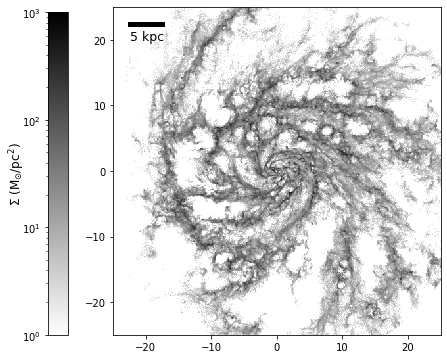

In [7]:
get_gas_plot(v,face,xh,yh)

# Fixing the coordinate system

In [9]:

rm = part.host['rotation']     

xGas_box = part['gas'].prop('host.distance')[:,0]
yGas_box = part['gas'].prop('host.distance')[:,1]
zGas_box = part['gas'].prop('host.distance')[:,2]

xGas_llc=ll_coordinate_transformation(rm, xGas_box, yGas_box, zGas_box)[:,0]
yGas_llc=ll_coordinate_transformation(rm, xGas_box, yGas_box, zGas_box)[:,1]
zGas_llc=ll_coordinate_transformation(rm, xGas_box, yGas_box, zGas_box)[:,2]

In [20]:
v_llc =  np.where((rGas <= bin_edge) & (np.fabs(zGas) <= 1.5) & (tGas <= 1e4)) #remember to use z from (host.distance.principal.cartesian)
face_llc, xh_llc, yh_llc = np.histogram2d(yGas_llc[v_llc],xGas_llc[v_llc],bins=[bins,bins], weights=mGas[v_llc])

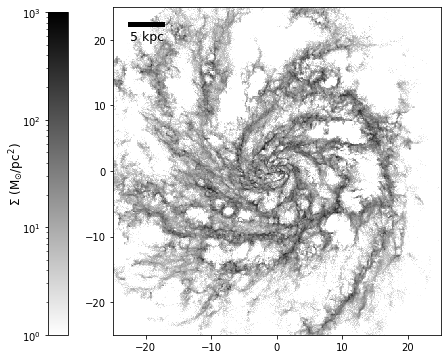

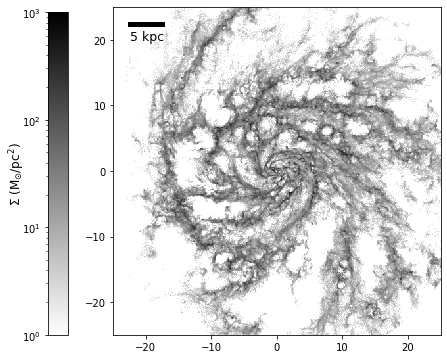

In [22]:
get_gas_plot(v_llc,face_llc,xh_llc,yh_llc)
get_gas_plot(v,face,xh,yh)

# Code to get gas background with fixed LLC

In [ ]:
part = gizmo.io.Read.read_snapshots(['all'],'snapshot_index', 685, simulation_name=simname, simulation_directory=simdir, assign_hosts_rotation=True, assign_hosts=True)  


In [25]:
t = np.max(part['star'].prop('form.time'))  

rGas = part['gas'].prop('host.distance.principal.cylindrical')[:,0]
zGas_pc = part['gas'].prop('host.distance.principal.cartesian')[:,2]

rm = part.host['rotation']     

xGas_box = part['gas'].prop('host.distance')[:,0]
yGas_box = part['gas'].prop('host.distance')[:,1]
zGas_box = part['gas'].prop('host.distance')[:,2]


mGas = part['gas']['mass']
rhoGas = part['gas']['density']
tGas = part['gas']['temperature']
idGas = part['gas']['id']


xGas_llc=ll_coordinate_transformation(rm, xGas_box, yGas_box, zGas_box)[:,0]
yGas_llc=ll_coordinate_transformation(rm, xGas_box, yGas_box, zGas_box)[:,1]

###########################################################################
#gas image (2d histogram)
###########################################################################
#cold (< 10^4 K) gas in the midplane (|z| <= 1.5 kpc within bin_edge
v_llc =  np.where((rGas <= bin_edge) & (np.fabs(zGas_pc) <= 1.5) & (tGas <= 1e4)) #remember to use z from (host.distance.principal.cartesian)
face_llc, xh_llc, yh_llc = np.histogram2d(yGas_llc[v_llc],xGas_llc[v_llc],bins=[bins,bins], weights=mGas[v_llc])

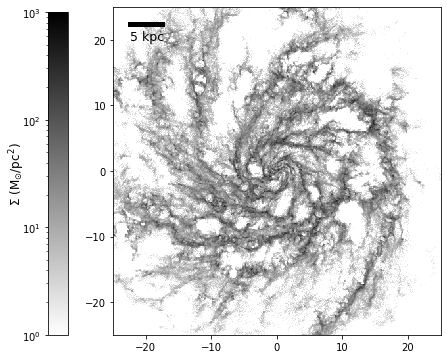

In [26]:
get_gas_plot(v_llc,face_llc,xh_llc,yh_llc)

In [ ]:
part = gizmo.io.Read.read_snapshots(['all'],'snapshot_index', 684, simulation_name=simname, simulation_directory=simdir, assign_hosts_rotation=True, assign_hosts=True)  


t = np.max(part['star'].prop('form.time'))  

rGas = part['gas'].prop('host.distance.principal.cylindrical')[:,0]
zGas_pc = part['gas'].prop('host.distance.principal.cartesian')[:,2]

rm = part.host['rotation']     

xGas_box = part['gas'].prop('host.distance')[:,0]
yGas_box = part['gas'].prop('host.distance')[:,1]
zGas_box = part['gas'].prop('host.distance')[:,2]


mGas = part['gas']['mass']
rhoGas = part['gas']['density']
tGas = part['gas']['temperature']
idGas = part['gas']['id']


xGas_llc=ll_coordinate_transformation(rm, xGas_box, yGas_box, zGas_box)[:,0]
yGas_llc=ll_coordinate_transformation(rm, xGas_box, yGas_box, zGas_box)[:,1]

###########################################################################
#gas image (2d histogram)
###########################################################################
#cold (< 10^4 K) gas in the midplane (|z| <= 1.5 kpc within bin_edge
v_llc =  np.where((rGas <= bin_edge) & (np.fabs(zGas_pc) <= 1.5) & (tGas <= 1e4)) #remember to use z from (host.distance.principal.cartesian)
face_llc, xh_llc, yh_llc = np.histogram2d(yGas_llc[v_llc],xGas_llc[v_llc],bins=[bins,bins], weights=mGas[v_llc])

get_gas_plot(v_llc,face_llc,xh_llc,yh_llc)


# Production Run Test

In [ ]:
#This file is designed to export gas data of the snapshots into a file that can be used to create plots with gas in the background
import numpy as np
import os
import pickle
import matplotlib
import gizmo_analysis as gizmo
import astropy
from astropy.io import ascii
#############################################################################
#constants
#############################################################################
MsunToGm = 1.99e33
KpcToCm = 3.086e21
mp = 1.67e-24
#bin_edge = 10.
bin_edge = 30.
bins = np.arange(-25,25,0.1)


############################################################################
#read in sim files and find relevant particles
############################################################################
simname = 'm12f_res7100_mhdcv'
simtype="fire2"  #this is the simtype eg. fire2, fire3, sf-fire3, sf-fire3-alpha01, sf-fire3-alpha03, sf-fire3-alpha05 
simdir = '/scratch/projects/xsede/GalaxiesOnFIRE/cr_suite/m12f_r7100/mhdcv/1Myr/'
work_data_path="/home1/07428/binod/work2/data/gas_data/"
gas_datapath=work_data_path+simname+"_gas_data_pkl_ll_coordinates/"  #path to store the gas data
if not os.path.exists(gas_datapath):
    os.makedirs(gas_datapath)
                
#snap=596 #this is the snapshot at which the clusters were taken from using the fof algorithm I am using this to extract information from the snapshot where the clusters were first seen
snapshot_start=588  #snapshot to begin creating the figure
snapshot_end=696    #snapshot to stop at

snapshot_list=np.arange(snapshot_start,snapshot_end+1) #create a list of snapshot numbers to plot to plot eg. [596,597, ...]
time=snapshot_list-snapshot_start #time starts from zero here where t=0 is at the snapshot where we start from eg. [0,1,2,3,....]

#reading in snapshot_times.txt file to get snapshot numbers and times
# columns are: snapshot scale-factor redshift time[Gyr] time_width[Myr]
snapshot_times = simdir + 'snapshot_times.txt'
snaptime_data = astropy.io.ascii.read(snapshot_times, guess=False, comment="#")
snaptime_data = np.genfromtxt(snapshot_times, usecols=(0,3), skip_header=4, dtype=float) #the first and fourth columns are the only ones we need 
snaps = np.array(snaptime_data[:,0]) #col1 = first column saved from text file #This is a collection of all snapshot nos.
times = np.array(snaptime_data[:,1]) #col4 = second column saved #This is a collection of times equivalent to those snapshot nos.
#######################################
#######################################





## NOTE: Inputs can be either position or velocity in the "Translated Box Coordinate Frame"
## If inputs are positions in the "Translated Box Coordinate Frame", outputs will be positions in the "Loebman Lab Coordinate Frame"
## If inputs are velocities in the "Translated Box Coordinate Frame", outputs will be velocities in the "Loebman Lab Coordinate Frame"

def ll_coordinate_transformation(rotation_matrix, x_translated_box_coordinate, y_translated_box_coordinate, z_translated_box_coordinate):
    
    # identifying the elements of the True Rotation Matrix
    rot_mat11 = rotation_matrix[0][0][0]
    rot_mat12 = rotation_matrix[0][0][1]
    rot_mat13 = rotation_matrix[0][0][2]
    
    rot_mat21 = rotation_matrix[0][1][0]
    rot_mat22 = rotation_matrix[0][1][1]
    rot_mat23 = rotation_matrix[0][1][2]
    
    rot_mat31 = rotation_matrix[0][2][0]
    rot_mat32 = rotation_matrix[0][2][1]
    rot_mat33 = rotation_matrix[0][2][2]
    
    ''' 
        Finding the three "True Rotation Angles": rot_angle_0, rot_angle_1 and rot_angle_2
        
        Note that there are eight possible sets of rotation angles.

        We use the following approach to know which set of rotation angles is the "True Rotation Angles" set.
        For each of the eight possible sets of rotation angles, 
        we compute the rotation matrix (let's call it the Recovered Rotation Matrix), 
        and we check which of these "Recovered Rotation Matrices" matches the "True Rotation Matrix."
        
    '''
    
    rot_angle_0 = [] 
    rot_angle_1 = []
    rot_angle_2 = []

    for k in range (2):
        for j in range (2):
            for i in range (2):
                recovered_rotation_angles = [0, 0, 0]
                recovered_rotation_angles[0] =  np.arctan(-rot_mat32/rot_mat33) + (i*np.pi)
                recovered_rotation_angles[1] =  np.arctan(rot_mat31/(np.sqrt(1- (rot_mat31**2)))) + (j*np.pi)
                recovered_rotation_angles[2] =  np.arctan(-rot_mat21/rot_mat11) + (k*np.pi)

                recovered_rot_mat11 = np.cos(recovered_rotation_angles[1]) * np.cos(recovered_rotation_angles[2])
                recovered_rot_mat12 = np.cos(recovered_rotation_angles[0]) * np.sin(recovered_rotation_angles[2]) + np.sin(recovered_rotation_angles[0]) * np.sin(recovered_rotation_angles[1]) * np.cos(recovered_rotation_angles[2])
                recovered_rot_mat13 = np.sin(recovered_rotation_angles[0]) * np.sin(recovered_rotation_angles[2]) - np.cos(recovered_rotation_angles[0]) * np.sin(recovered_rotation_angles[1]) * np.cos(recovered_rotation_angles[2])
                recovered_rot_mat21 = -np.cos(recovered_rotation_angles[1]) * np.sin(recovered_rotation_angles[2])
                recovered_rot_mat22 = np.cos(recovered_rotation_angles[0]) * np.cos(recovered_rotation_angles[2]) - np.sin(recovered_rotation_angles[0]) * np.sin(recovered_rotation_angles[1]) * np.sin(recovered_rotation_angles[2])
                recovered_rot_mat23 = np.sin(recovered_rotation_angles[0]) * np.cos(recovered_rotation_angles[2]) + np.cos(recovered_rotation_angles[0]) * np.sin(recovered_rotation_angles[1]) * np.sin(recovered_rotation_angles[2])
                recovered_rot_mat31 = np.sin(recovered_rotation_angles[1])
                recovered_rot_mat32 = -np.sin(recovered_rotation_angles[0]) * np.cos(recovered_rotation_angles[1])
                recovered_rot_mat33 = np.cos(recovered_rotation_angles[0]) * np.cos(recovered_rotation_angles[1])

                if ((np.round(recovered_rot_mat11.astype('float64'), 3) == np.round(rot_mat11.astype('float64'), 3)) & 
                    (np.round(recovered_rot_mat12.astype('float64'), 3) == np.round(rot_mat12.astype('float64'), 3)) & 
                    (np.round(recovered_rot_mat13.astype('float64'), 3) == np.round(rot_mat13.astype('float64'), 3)) &
                    (np.round(recovered_rot_mat21.astype('float64'), 3) == np.round(rot_mat21.astype('float64'), 3)) &
                    (np.round(recovered_rot_mat22.astype('float64'), 3) == np.round(rot_mat22.astype('float64'), 3)) &
                    (np.round(recovered_rot_mat23.astype('float64'), 3) == np.round(rot_mat23.astype('float64'), 3)) &
                    (np.round(recovered_rot_mat31.astype('float64'), 3) == np.round(rot_mat31.astype('float64'), 3)) &
                    (np.round(recovered_rot_mat32.astype('float64'), 3) == np.round(rot_mat32.astype('float64'), 3)) &
                    (np.round(recovered_rot_mat33.astype('float64'), 3) == np.round(rot_mat33.astype('float64'), 3))):

                    rot_angle_0.append(recovered_rotation_angles[0])
                    rot_angle_1.append(recovered_rotation_angles[1])
                    rot_angle_2.append(recovered_rotation_angles[2])

                    break
                    del(recovered_rotation_angles)
                    
    ''' 
        Constructing the "Loebman Lab Transformation Matrix": ll_tans_matij   
    '''
    
    ll_trans_mat11 = np.cos(rot_angle_1)
    ll_trans_mat12 = np.sin(rot_angle_0) * np.sin(rot_angle_1)
    ll_trans_mat13 = - np.cos(rot_angle_0) * np.sin(rot_angle_1)
    ll_trans_mat21 = np.zeros(1)
    ll_trans_mat22 = np.cos(rot_angle_0)
    ll_trans_mat23 = np.sin(rot_angle_0) 
    ll_trans_mat31 = np.sin(rot_angle_1)
    ll_trans_mat32 = -np.sin(rot_angle_0) * np.cos(rot_angle_1)
    ll_trans_mat33 = np.cos(rot_angle_0) * np.cos(rot_angle_1)
    
    '''
        Finding coordinate of particles in the "Loebman Lab Coordinate System": x_ll, y_ll and z_ll
    '''
    
    x_ll = (ll_trans_mat11*x_translated_box_coordinate) + (ll_trans_mat12*y_translated_box_coordinate) + (ll_trans_mat13*z_translated_box_coordinate)
    y_ll = (ll_trans_mat21*x_translated_box_coordinate) + (ll_trans_mat22*y_translated_box_coordinate) + (ll_trans_mat23*z_translated_box_coordinate)
    z_ll = (ll_trans_mat31*x_translated_box_coordinate) + (ll_trans_mat32*y_translated_box_coordinate) + (ll_trans_mat33*z_translated_box_coordinate)
    
    position_ll = np.asarray((x_ll, y_ll, z_ll)).T
    
    return position_ll 


tracked_gas_all_snaps={}
for i in range(len(time)):                              
    snapnumber=time[i]+snapshot_start      #this is the true snapshot number each time for eg, 596, 597 .. and son
    snaptime = times[np.where(snaps == snapnumber)][0] #time of snapshot in Gyr
    tracked_gas={} 
    part = gizmo.io.Read.read_snapshots(['all'],'snapshot_index', time[i]+snapshot_start, simulation_name=simname, simulation_directory=simdir, assign_hosts_rotation=True, assign_hosts=True)  
    t = np.max(part['star'].prop('form.time'))  
    
    rGas = part['gas'].prop('host.distance.principal.cylindrical')[:,0]
    zGas_pc = part['gas'].prop('host.distance.principal.cartesian')[:,2]

    rm = part.host['rotation']     

    xGas_box = part['gas'].prop('host.distance')[:,0]
    yGas_box = part['gas'].prop('host.distance')[:,1]
    zGas_box = part['gas'].prop('host.distance')[:,2]


    mGas = part['gas']['mass']
    rhoGas = part['gas']['density']
    tGas = part['gas']['temperature']
    idGas = part['gas']['id']


    xGas_llc=ll_coordinate_transformation(rm, xGas_box, yGas_box, zGas_box)[:,0]
    yGas_llc=ll_coordinate_transformation(rm, xGas_box, yGas_box, zGas_box)[:,1]

    ###########################################################################
    #gas image (2d histogram)
    ###########################################################################
    #cold (< 10^4 K) gas in the midplane (|z| <= 1.5 kpc within bin_edge
    v_llc =  np.where((rGas <= bin_edge) & (np.fabs(zGas_pc) <= 1.5) & (tGas <= 1e4)) #remember to use z from (host.distance.principal.cartesian)
    face_llc, xh_llc, yh_llc = np.histogram2d(yGas_llc[v_llc],xGas_llc[v_llc],bins=[bins,bins], weights=mGas[v_llc])
    
    ###########################################################################
    tracked_gas={"snaptime":snaptime,"v":v_llc,"face":face_llc,"xh":xh_llc,"yh":yh_llc}
    file_name=simtype+simname+"_gas_data"+str(snapnumber)+".pkl"
    with open(gas_datapath+file_name, 'wb') as output:
        pickle.dump(tracked_gas, output)
    print("\n Stored the gas data for background plot from the snapshot no.",snapnumber,"to filename:",file_name,"\n#####\n")
    '''
    This is how to read the data:
    file_name="gas_data_snapshot_"+str(snapnumber)+".pkl"
    with open(gas_datapath+file_name, "rb") as input:
      import_gasdata = pickle.load(input)
    print(import_gasdata["v"])
    '''
    #tracked_gas_all_snaps.update({snapnumber:tracked_gas})
    
    
    
###########################################
#storing all the gas data from all snapshots as a single file
'''
with open(gas_datapath+simtype+"_gas_data_all_snapshots.pkl", 'wb') as output:
  pickle.dump(tracked_gas_all_snaps, output) #
  
#read it as tracked_gas_all_snaps[snap]["v"]
'''

